<a id='start'></a>
# Serie storiche

In questo notebook vengono presentati degli esercizi sulle serie storiche (_time series_).

Provate a svolgere il seguente esercizio:<br>
1) [Analisi di una time series](#section1)<br>
2) [Scomposizione nelle componenti principali](#section2)<br>
3) [Eliminazione di trend e stagionalità](#section3)<br>
4) [Predizione sulla serie originale](#section4)<br>

<a id='section1'></a>
## Analisi di una time series

Analizziamo i dati dei passeggeri dei voli di linea negli Stati Uniti:

In [1]:
import pandas as pd

df = pd.read_csv('data/AirPassengers.csv', parse_dates=['date'], index_col='date')
df

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Effettuiamo la visualizzazione dei dati con un grafico a linee (sia normale che con two sided view):

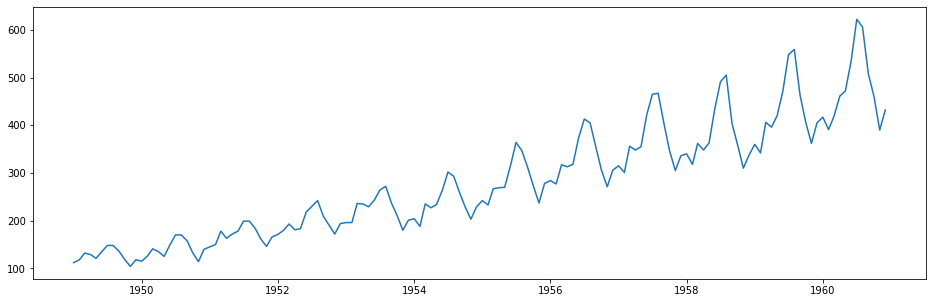

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
plt.plot(df.index, df.value)
plt.show()


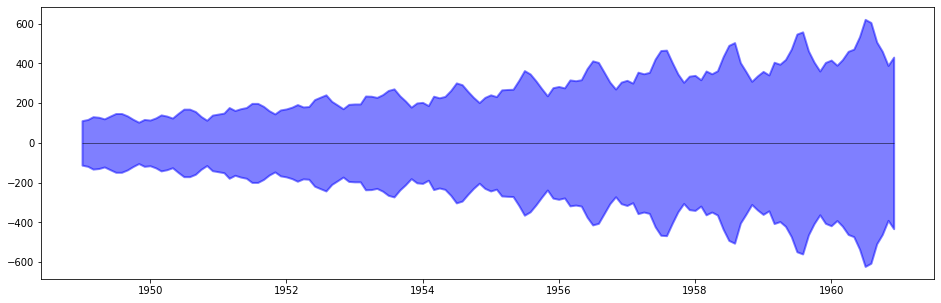

In [5]:
import numpy as np

plt.figure(figsize=(16,5))
plt.fill_between(df.index, y1=df.value, y2=-df.value, alpha=0.5, linewidth=2, color='blue')
plt.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=.5)
plt.show()

Analizziamo l'autocorrelazione di questa serie:

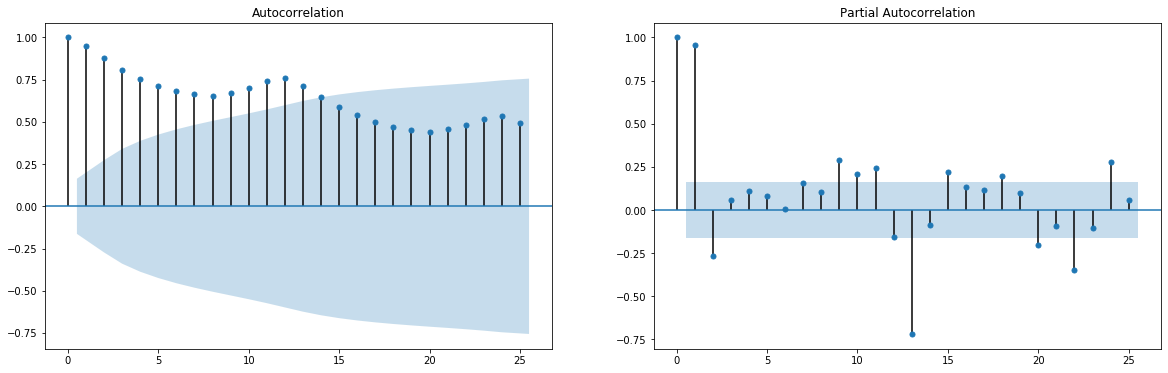

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(20,6))
plot_acf(df.value.tolist(), lags=25, ax=axes[0])
plot_pacf(df.value.tolist(), lags=25, ax=axes[1])
plt.show()

I dati presentati in questa serie mostrano una certa autocorrelazione ed è possibile vedere che i dati hanno una stagionalità circa annuale (come era facile prevedere).

Proseguiamo quindi con un'analisi di stazionarietà:

In [8]:
from statsmodels.tsa.stattools import adfuller

X = df.values
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


Dal valore di questa statistica sembra che la serie non sia stazionaria ma abbia un trend o una stagionalità (in realtà possiamo immaginare le abbia entrambe). La serie è molto più probabilmente stazionaria quanto più il valore del Augmented Dickey-Fuller test (ADF) è negativo.

<a id='section2'></a>
## Scomposizione nelle componenti principali

Eseguiamo le tecniche viste per realizzare una scomposizione nelle componenti principali dei dati di questa serie storica:

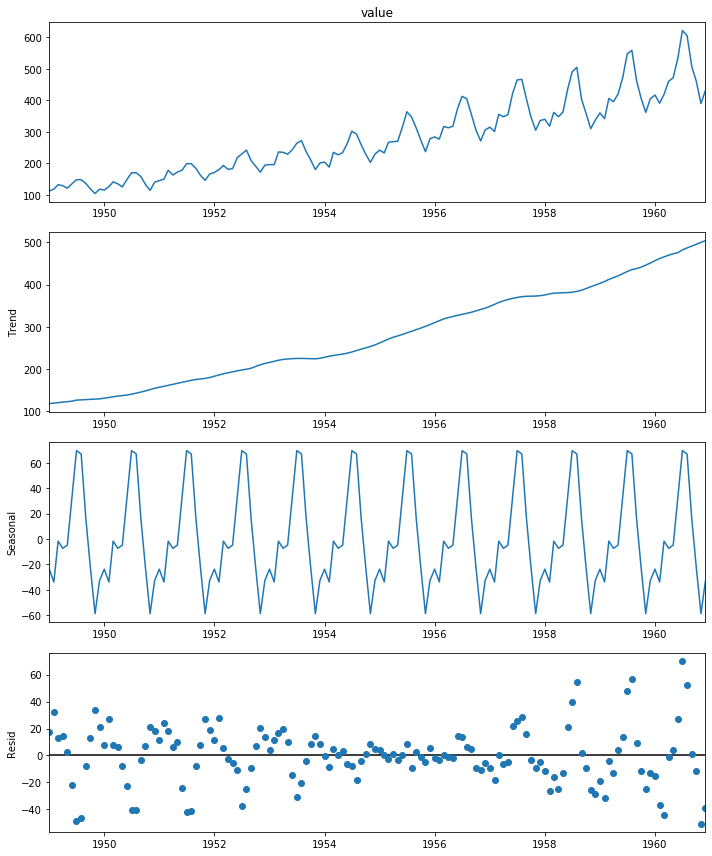

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10, 12)})
result_add.plot()
plt.show()

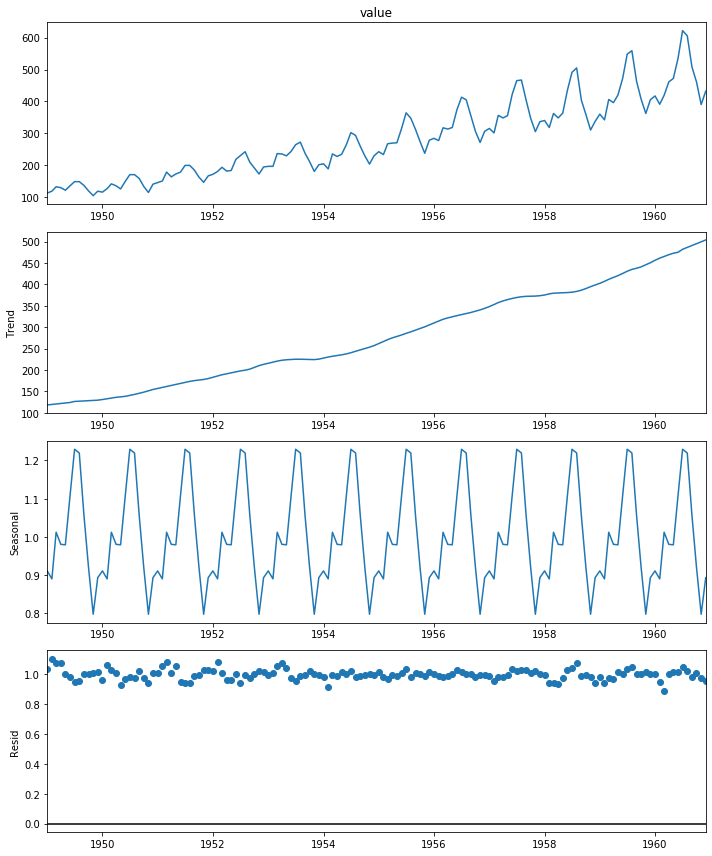

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
result_add = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10, 12)})
result_add.plot()
plt.show()

<a id='section3'></a>
## Eliminazione di trend e stagionalità

Eliminiamo il trend:

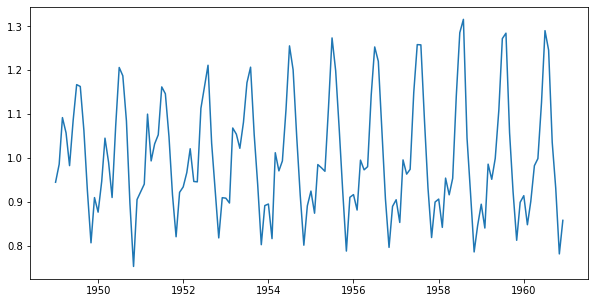

In [13]:
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
detrended = df.value.values / result_mul.trend

plt.rcParams.update({'figure.figsize': (10, 5)})
plt.plot(df.index, detrended)
plt.show()

Eliminiamo la stagionalità:

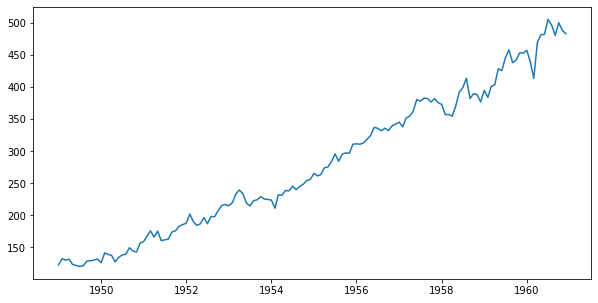

In [15]:
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
deseasonalized = df.value.values / result_mul.seasonal

plt.rcParams.update({'figure.figsize': (10, 5)})
plt.plot(df.index, deseasonalized)
plt.show()

Eliminiamo sia trand che stagionalità:

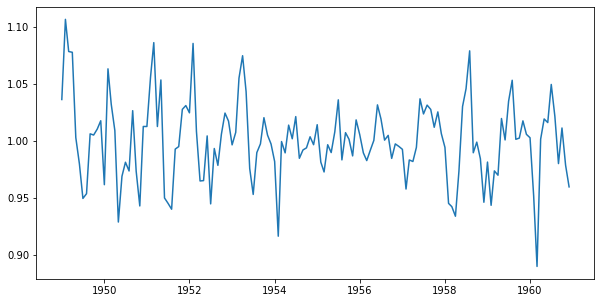

In [16]:
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
deseasoned = df.value.values / result_mul.seasonal
deseasoned_detrended = deseasoned / result_mul.trend

plt.rcParams.update({'figure.figsize': (10, 5)})
plt.plot(df.index, deseasoned_detrended)
plt.show()

Proviamo a fare un'analisi di stazionarietà sulla serie così ottenuta:

In [17]:
new_df = df.copy()
new_df['value'] = deseasoned_detrended

from statsmodels.tsa.stattools import adfuller

result = adfuller(new_df.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.590191
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


I risultati di questa statistica ci dicono che la sere ottenuta è stazionaria con livello di significatività inferiore all'1%.

<a id='section4'></a>
## Predizione della serie originale

Proviamo a provedere i prossimi 3 anni (36 mesi) dei dati di questa serie:

In [21]:
import pmdarima as pm

smodel = pm.auto_arima(df, start_p=1, start_q=1,
                       test='adf',
                       max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=1024.824, BIC=1039.200, Time=2.182 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=1033.479, BIC=1039.229, Time=0.052 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=1022.316, BIC=1033.817, Time=0.449 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=1022.904, BIC=1034.405, Time=0.348 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=1031.508, BIC=1034.383, Time=0.019 seconds
Fit ARIMA(1,1,0)x(0,1,0,12) [intercept=True]; AIC=1022.343, BIC=1030.968, Time=0.104 seconds
Fit ARIMA(1,1,0)x(2,1,0,12) [intercept=True]; AIC=1021.137, BIC=1035.513, Time=1.415 seconds
Fit ARIMA(1,1,0)x(2,1,1,12) [intercept=True]; AIC=1017.164, BIC=1034.415, Time=5.032 seconds
Near non-invertible roots for order (1, 1, 0)(2, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(1,1,0)x(1,1,1,12) [intercept=True]; AIC=102

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -501.922
Date:                            Thu, 07 May 2020   AIC                           1015.844
Time:                                    07:17:01   BIC                           1033.095
Sample:                                         0   HQIC                          1022.854
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.033      0.013      0.990      -0.065       0.066
ma.L1         -0.4235      0.068     -6.194      0.000      -0.558      -0.290
ar.S.L12       0.6663      0.158      4.229      0.000       0.358       0.975
ar.S.L24       0.3318      0.096      3.469      0.001       0.144       0.519
ma.S.L12      -0.9712      1.091     -0.890      0.373      -3.109       1.167
sigma2       110.8287     98.274      1.128      0.259     -81.785     303.443
===================================================================================
Ljung-Box (Q):                       53.12   Jarque-Bera (JB):                 7.55
Prob(Q):                              0.08   Prob(JB):                         0.02
Heteroskedasticity (H):               2.82   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

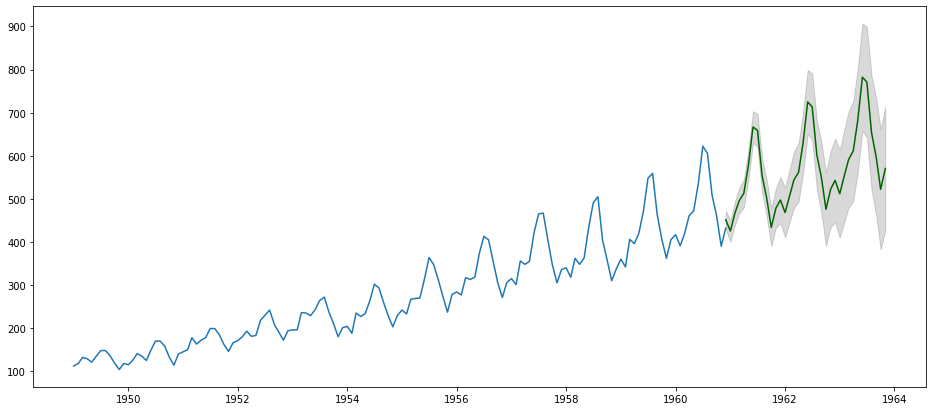

In [29]:
# Forecast
n_periods = 36
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods=n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(df)

plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.show()

[Clicca qui per tornare all'inizio della pagina](#start)<a id='start'></a>